In [2]:
import kagglehub

path = kagglehub.dataset_download("bricevergnou/spotify-recommendation")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\nabil\.cache\kagglehub\datasets\bricevergnou\spotify-recommendation\versions\2


In [3]:
path

'C:\\Users\\nabil\\.cache\\kagglehub\\datasets\\bricevergnou\\spotify-recommendation\\versions\\2'

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('data.csv')



In [13]:
data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.4510,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.2060,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.9920,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.4310,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.1450,0.000000,0.0753,0.6470,155.117,179413,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.166,0.0551,9,-19.494,0,0.0520,0.9760,0.635000,0.1190,0.1430,176.616,206520,3,0
191,0.862,0.6240,3,-11.630,1,0.0565,0.0192,0.000153,0.0465,0.8820,124.896,254240,4,0
192,0.499,0.3510,9,-11.509,0,0.0448,0.9510,0.000099,0.1180,0.6160,90.664,235947,4,0
193,0.574,0.7290,10,-5.838,0,0.0965,0.0406,0.000004,0.1940,0.4130,110.547,190239,5,1


In [5]:
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64

In [6]:
print(df["liked"].value_counts())


liked
1    100
0     95
Name: count, dtype: int64


In [14]:

X = data.drop('liked', axis=1)
y = data['liked']


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)


best_rf = grid_search.best_estimator_

In [18]:

y_pred = best_rf.predict(X_test_scaled)

In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9487179487179487

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.95      0.95      0.95        20

    accuracy                           0.95        39
   macro avg       0.95      0.95      0.95        39
weighted avg       0.95      0.95      0.95        39



In [20]:
def recommend_songs(input_features, dataset, model, scaler, n_recommendations=5):
    """
    Merekomendasikan lagu berdasarkan fitur input
    
    Parameters:
    - input_features: Dictionary berisi fitur lagu (contoh: {'danceability': 0.8, 'energy': 0.7, ...})
    - dataset: DataFrame lengkap dengan semua lagu
    - model: Model machine learning yang sudah trained
    - scaler: Scaler yang sudah fitted
    - n_recommendations: Jumlah rekomendasi yang ingin diberikan
    
    Returns:
    - DataFrame berisi lagu-lagu rekomendasi
    """
    # Konversi input ke DataFrame
    input_df = pd.DataFrame([input_features])
    
    # Normalisasi input
    input_scaled = scaler.transform(input_df)
    
    # Prediksi probabilitas
    proba = model.predict_proba(input_scaled)[0][1]  # Probabilitas disukai
    
    # Cari lagu dengan fitur serupa yang disukai
    liked_songs = dataset[dataset['liked'] == 1]
    
    # Hitung similarity score 
    input_scaled_repeated = np.repeat(input_scaled, len(liked_songs), axis=0)
    liked_songs_scaled = scaler.transform(liked_songs.drop('liked', axis=1))
    distances = np.linalg.norm(input_scaled_repeated - liked_songs_scaled, axis=1)
    
   
    liked_songs['similarity'] = 1 / (1 + distances)
    liked_songs['input_probability'] = proba
    
    # Mengurutkan  berdasarkan similarity dan probabilitas input
    recommended = liked_songs.sort_values(['similarity', 'input_probability'], ascending=[False, False])
    
    return recommended.head(n_recommendations)

In [ ]:

input_features = {
    'danceability': 0.8,
    'energy': 0.7,
    'key': 5,
    'loudness': -6.0,
    'mode': 1,
    'speechiness': 0.1,
    'acousticness': 0.3,
    'instrumentalness': 0.0,
    'liveness': 0.1,
    'valence': 0.7,
    'tempo': 120.0,
    'duration_ms': 200000,
    'time_signature': 4
}

# Dapatkan rekomendasi
recommendations = recommend_songs(input_features, data, best_rf, scaler)
print("Recommended Songs:")
print(recommendations[['danceability', 'energy', 'valence', 'tempo', 'similarity']])

Recommended Songs:
     danceability  energy  valence    tempo  similarity
98          0.764   0.812    0.742  139.961    0.430474
139         0.827   0.703    0.586  137.043    0.399533
5           0.778   0.632    0.827  140.951    0.388447
149         0.829   0.708    0.723  139.961    0.378307
165         0.720   0.670    0.766  151.124    0.377159


C:\Users\nabil\AppData\Local\Temp\ipykernel_18092\3097250652.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liked_songs['similarity'] = 1 / (1 + distances)
C:\Users\nabil\AppData\Local\Temp\ipykernel_18092\3097250652.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liked_songs['input_probability'] = proba



Feature Importance:
             feature  importance
7   instrumentalness    0.231936
5        speechiness    0.176697
11       duration_ms    0.113384
0       danceability    0.100027
10             tempo    0.097929
9            valence    0.080742
3           loudness    0.057270
1             energy    0.048505
6       acousticness    0.046242
8           liveness    0.018193
2                key    0.015097
4               mode    0.010090
12    time_signature    0.003888


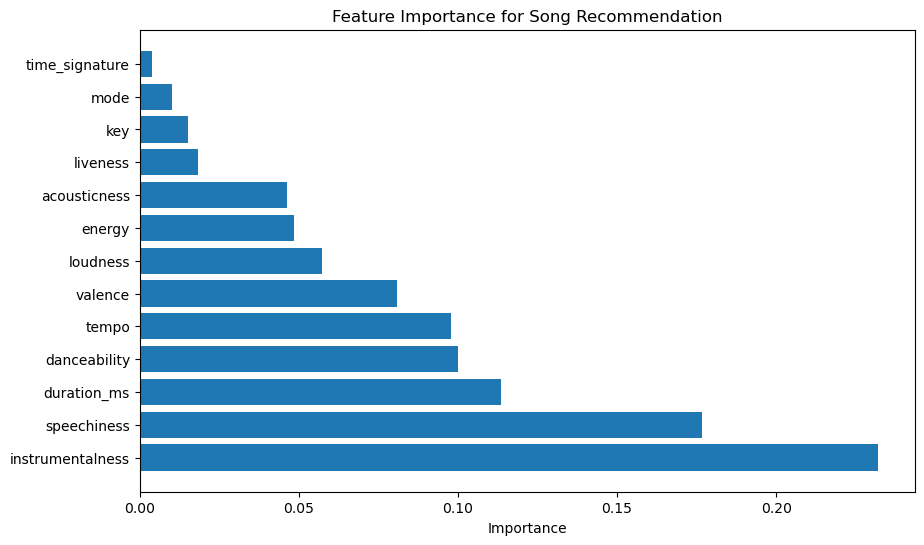

In [ ]:

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Song Recommendation')
plt.show()

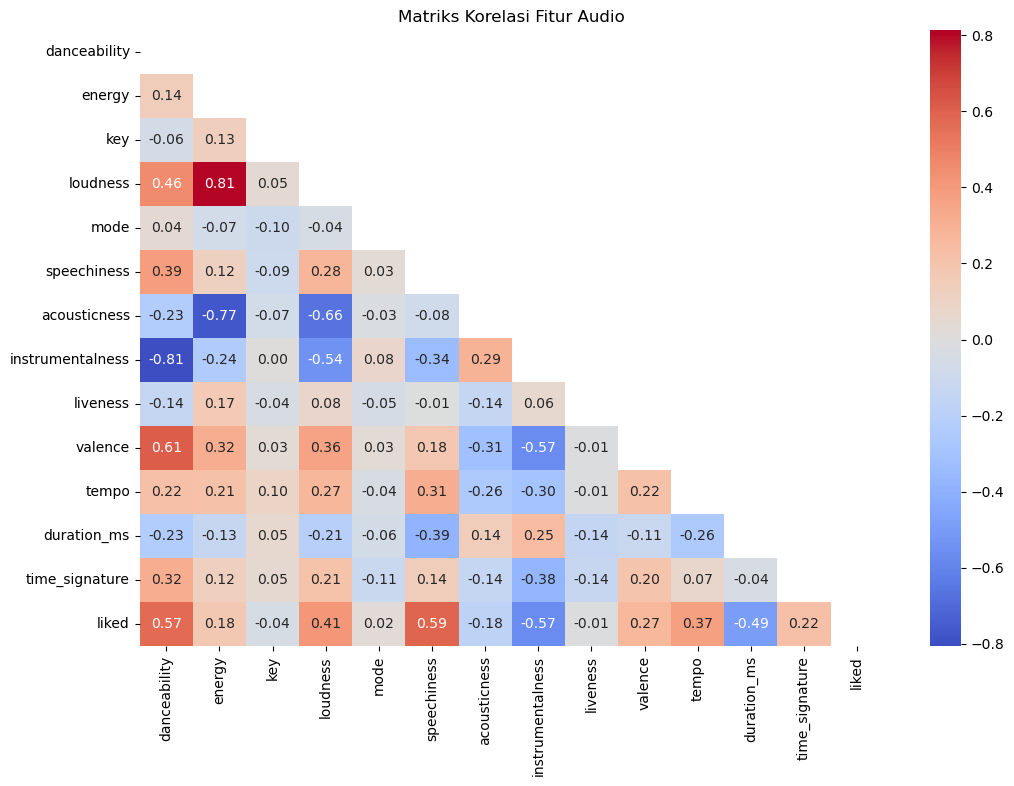

In [24]:
import seaborn as sns
plt.figure(figsize=(12, 8))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Matriks Korelasi Fitur Audio')
plt.show()